<a href="https://colab.research.google.com/github/MohammadAliAfsahi/AdclickPrediction/blob/master/DataDays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls '/content/drive/My Drive/datadays2020_contest_public_dataset'

ad.csv	      click_test.csv   page.csv
ad_image.csv  click_train.csv  page_topic.csv
ad_title.csv  event.csv        user_page_view.csv


In [0]:
import numpy as np
import ast
import pandas as pd
from datetime import datetime
import pytz
import time

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn import cluster

In [0]:
RANDOM_STATE = 42

In [0]:
path = '/content/drive/My Drive/datadays2020_contest_public_dataset/'

advertisements = pd.read_csv(path + 'ad.csv')
advertisements_images = pd.read_csv(path + 'ad_image.csv')
advertisements_titles = pd.read_csv(path + 'ad_title.csv')
clicked_train = pd.read_csv(path + 'click_train.csv')
event = pd.read_csv(path + 'event.csv')
page = pd.read_csv(path + 'page.csv')
page_topic = pd.read_csv(path + 'page_topic.csv')
user_views = pd.read_csv(path + 'user_page_view.csv')
 
click_test = pd.read_csv(path + 'click_test.csv')

In [0]:
advertisements.head()

,adId,campaignId,advertiserId
0,7867,5918,8414
1,7866,5918,8414
2,7865,5918,8414
3,7863,8343,8414
4,7862,8343,8414


In [0]:
print("min campaignId : ", min(advertisements['campaignId']), ", max campaingId : ", max(advertisements['campaignId']))

min campaignId :  30 , max campaingId :  9523


In [0]:
advertisements.isna().sum()

adId            0
campaignId      0
advertiserId    0
dtype: int64

In [0]:
print("# of unique advertisements : ", advertisements.loc[:, 'adId'].nunique())
print("# of unique campaigns : ", advertisements.loc[:, 'campaignId'].nunique())
print("# of unique advertisers : ", advertisements.loc[:, 'advertiserId'].nunique())

# of unique advertisements :  3256
# of unique campaigns :  528
# of unique advertisers :  213


In [0]:
advertisements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3256 entries, 0 to 3255
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   adId          3256 non-null   int64
 1   campaignId    3256 non-null   int64
 2   advertiserId  3256 non-null   int64
dtypes: int64(3)
memory usage: 76.4 KB


In [0]:
advertisements_images.head()

,adId,imageFeatures
0,7867,"[0.0524589940905571, 0.0, 0.04262353479862213,..."
1,7866,"[0.0032160670962184668, 0.1444239318370819, 0...."
2,7865,"[0.027210379019379616, 0.0, 0.5133526921272278..."
3,7863,"[0.0013980235671624541, 0.0, 0.0, 0.0455568209..."
4,7862,"[0.02426762878894806, 0.026081759482622147, 0...."


In [0]:
print("# of unique advertisements_images : ", advertisements_images.loc[:, 'imageFeatures'].nunique())
print("# of unique advertisements : ", advertisements_images.loc[:, 'adId'].nunique())

# of unique advertisements_images :  2692
# of unique advertisements :  3256


In [0]:
advertisements_images.isna().sum()

adId             0
imageFeatures    0
dtype: int64

In [0]:
advertisements_images['image'] = advertisements_images.apply(lambda x: ast.literal_eval(x['imageFeatures']), axis=1)
advertisements_images['imageFeatures'] = advertisements_images['image']
advertisements_images.drop('image', axis=1, inplace=True)

In [0]:
advertisements_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3256 entries, 0 to 3255
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   adId           3256 non-null   int64 
 1   imageFeatures  3256 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


In [0]:
advertisements_images = pd.DataFrame(advertisements_images['imageFeatures'].tolist(), index=advertisements_images.adId)
advertisements_images.reset_index(level=0, inplace=True)

In [0]:
advertisements_titles.head()

,adId,wordId
0,6,24
1,6,25
2,6,26
3,6,27
4,6,28


In [0]:
print('min wordId : ', min(advertisements_titles['wordId']), ', max wordId : ', max(advertisements_titles['wordId']))

min wordId :  0 , max wordId :  2683


In [0]:
advertisements_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18122 entries, 0 to 18121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   adId    18122 non-null  int64
 1   wordId  18122 non-null  int64
dtypes: int64(2)
memory usage: 283.3 KB


In [0]:
print("# of unique words in advertisements_titles : ", advertisements_titles['wordId'].nunique())

# of unique words in advertisements_titles :  2108


In [0]:
advertisements_titles.isna().sum()

adId      0
wordId    0
dtype: int64

In [0]:
ad = pd.merge(advertisements, advertisements_titles, on='adId')
ad = pd.merge(ad, advertisements_images, on='adId')
ad.drop('adId', axis=1, inplace=True)

In [0]:
ad.iloc[:, 3:] = ad.astype(np.float32)
ad.iloc[:, :3] = ad.astype(np.int16)

In [0]:
ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18122 entries, 0 to 18121
Columns: 515 entries, campaignId to 511
dtypes: float32(512), int16(3)
memory usage: 35.6 MB


In [0]:
ad.head()

,campaignId,advertiserId,wordId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,5918,8414,11,0.052459,0.0,0.042624,0.333583,0.383563,0.001634,0.344869,0.525469,0.05376,0.079034,0.500915,0.677032,0.0,0.047452,0.113147,0.007646,0.0,0.150139,0.032419,0.004933,0.0,0.0,0.57306,0.019596,0.0,0.092233,0.025148,0.072606,0.0,0.537699,0.0,0.15406,0.955965,0.105462,0.00384,0.0,0.09895,...,0.0,0.0,1.014188,0.149694,0.106801,0.168865,0.019656,0.081902,0.339181,0.134276,0.016473,0.193523,0.409411,0.127201,0.406103,0.0,0.0,0.007431,0.295453,0.348585,0.1128,0.0,0.281564,0.044966,0.145961,0.0,0.144654,0.090878,0.076503,0.223643,0.233728,0.53948,0.152508,0.344518,0.778731,0.078295,0.160162,0.0,0.305145,0.018119
1,5918,8414,209,0.052459,0.0,0.042624,0.333583,0.383563,0.001634,0.344869,0.525469,0.05376,0.079034,0.500915,0.677032,0.0,0.047452,0.113147,0.007646,0.0,0.150139,0.032419,0.004933,0.0,0.0,0.57306,0.019596,0.0,0.092233,0.025148,0.072606,0.0,0.537699,0.0,0.15406,0.955965,0.105462,0.00384,0.0,0.09895,...,0.0,0.0,1.014188,0.149694,0.106801,0.168865,0.019656,0.081902,0.339181,0.134276,0.016473,0.193523,0.409411,0.127201,0.406103,0.0,0.0,0.007431,0.295453,0.348585,0.1128,0.0,0.281564,0.044966,0.145961,0.0,0.144654,0.090878,0.076503,0.223643,0.233728,0.53948,0.152508,0.344518,0.778731,0.078295,0.160162,0.0,0.305145,0.018119
2,5918,8414,245,0.052459,0.0,0.042624,0.333583,0.383563,0.001634,0.344869,0.525469,0.05376,0.079034,0.500915,0.677032,0.0,0.047452,0.113147,0.007646,0.0,0.150139,0.032419,0.004933,0.0,0.0,0.57306,0.019596,0.0,0.092233,0.025148,0.072606,0.0,0.537699,0.0,0.15406,0.955965,0.105462,0.00384,0.0,0.09895,...,0.0,0.0,1.014188,0.149694,0.106801,0.168865,0.019656,0.081902,0.339181,0.134276,0.016473,0.193523,0.409411,0.127201,0.406103,0.0,0.0,0.007431,0.295453,0.348585,0.1128,0.0,0.281564,0.044966,0.145961,0.0,0.144654,0.090878,0.076503,0.223643,0.233728,0.53948,0.152508,0.344518,0.778731,0.078295,0.160162,0.0,0.305145,0.018119
3,5918,8414,1992,0.052459,0.0,0.042624,0.333583,0.383563,0.001634,0.344869,0.525469,0.05376,0.079034,0.500915,0.677032,0.0,0.047452,0.113147,0.007646,0.0,0.150139,0.032419,0.004933,0.0,0.0,0.57306,0.019596,0.0,0.092233,0.025148,0.072606,0.0,0.537699,0.0,0.15406,0.955965,0.105462,0.00384,0.0,0.09895,...,0.0,0.0,1.014188,0.149694,0.106801,0.168865,0.019656,0.081902,0.339181,0.134276,0.016473,0.193523,0.409411,0.127201,0.406103,0.0,0.0,0.007431,0.295453,0.348585,0.1128,0.0,0.281564,0.044966,0.145961,0.0,0.144654,0.090878,0.076503,0.223643,0.233728,0.53948,0.152508,0.344518,0.778731,0.078295,0.160162,0.0,0.305145,0.018119
4,5918,8414,2683,0.052459,0.0,0.042624,0.333583,0.383563,0.001634,0.344869,0.525469,0.05376,0.079034,0.500915,0.677032,0.0,0.047452,0.113147,0.007646,0.0,0.150139,0.032419,0.004933,0.0,0.0,0.57306,0.019596,0.0,0.092233,0.025148,0.072606,0.0,0.537699,0.0,0.15406,0.955965,0.105462,0.00384,0.0,0.09895,...,0.0,0.0,1.014188,0.149694,0.106801,0.168865,0.019656,0.081902,0.339181,0.134276,0.016473,0.193523,0.409411,0.127201,0.406103,0.0,0.0,0.007431,0.295453,0.348585,0.1128,0.0,0.281564,0.044966,0.145961,0.0,0.144654,0.090878,0.076503,0.223643,0.233728,0.53948,0.152508,0.344518,0.778731,0.078295,0.160162,0.0,0.305145,0.018119


In [0]:
X = advertisements_images.iloc[:, 1:]
bw = cluster.estimate_bandwidth(X, random_state=RANDOM_STATE)
cl = cluster.MeanShift(bandwidth=bw).fit(X)

In [0]:
advertisements_images['pic'] = cl.labels_

In [0]:
advertisements_images[advertisements_images['pic'] == 60]

,adId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,pic


In [0]:
advertisements_titles[advertisements_titles.adId == 6120]

,adId,wordId
8817,6120,11
8818,6120,57
8819,6120,1751


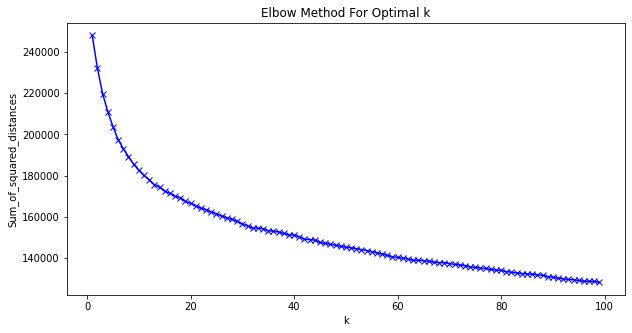

In [0]:
SS = []
k = range(1, 100)
for i in k:
  clk = cluster.KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(X)
  SS.append(clk.inertia_)

plt.figure(figsize=(10,5))
plt.plot(k, SS, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
plt.figure(figsize=(10,5))
plt.plot(k, SS, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
clk = cluster.KMeans(n_clusters=20, random_state=RANDOM_STATE).fit(X)


In [0]:
clicked_train.head()

,displayId,adId,clicked
0,1210227,7182,0
1,1210227,7125,0
2,1210227,7181,0
3,1210227,535,0
4,1210227,7174,1


In [0]:
clicked_train.isna().sum()

displayId    0
adId         0
clicked      0
dtype: int64

In [0]:
clicked_train['clicked'] = clicked_train['clicked'].astype(np.int8)

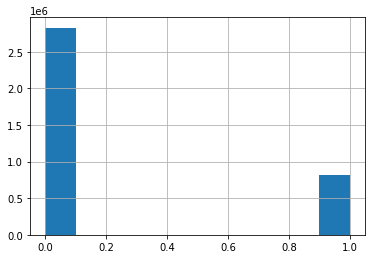

In [0]:
clicked_train['clicked'].hist()

In [0]:
clicked_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642244 entries, 0 to 3642243
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   displayId  int64
 1   adId       int64
 2   clicked    int8 
dtypes: int64(2), int8(1)
memory usage: 59.0 MB


In [0]:
advertisements['adId'].isin(clicked_train['adId']).value_counts()

True     2616
False     640
Name: adId, dtype: int64

In [0]:
advertisements['adId'].isin(advertisements_titles['adId']).value_counts()

True     3252
False       4
Name: adId, dtype: int64

In [0]:
event.head()

,displayId,timestamp,pageId,widgetId,userId,device,OS,browser
0,4706262,1578429005696,3543873,6262,2688642,0,0,0
1,4706267,1578429007726,6245475,607,2688641,1,3,0
2,4706260,1578429012060,4416499,11458,2688638,0,0,1
3,4706255,1578429017218,6246028,9358,1962852,0,0,0
4,4706256,1578429021388,5327047,9358,2687719,0,0,0


In [0]:
event = event.astype({'device': np.int8, 'OS': np.int8, 'browser': np.int8, 'partOfDay': np.int8, 'weekend': np.int8})

In [0]:
tz = pytz.timezone("Asia/Tehran")
event['timestamp'] = event['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000, tz))

In [0]:
event.isna().sum()

displayId    0
timestamp    0
pageId       0
widgetId     0
userId       0
device       0
OS           0
browser      0
dtype: int64

In [0]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083071 entries, 0 to 1083070
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   displayId  1083071 non-null  int64
 1   pageId     1083071 non-null  int64
 2   widgetId   1083071 non-null  int64
 3   userId     1083071 non-null  int64
 4   device     1083071 non-null  int8 
 5   OS         1083071 non-null  int8 
 6   browser    1083071 non-null  int8 
 7   partOfDay  1083071 non-null  int8 
 8   weekend    1083071 non-null  int8 
dtypes: int64(4), int8(5)
memory usage: 38.2 MB


In [0]:
def partOfDay(hour):
  '''
  Six values: Early Morning, Morning, Noon, Evening, Night, Late Night
  '''
  if hour >= 3 and hour < 8:
    return 0 # Early morning
  elif hour >=8 and hour < 12:
    return 1 # Morning
  elif hour >= 12 and hour < 17:
    return 2 # Noon
  elif hour >=17 and hour < 20:
    return 3 # Evening
  elif hour >= 20 and hour <= 23:
    return 4 # Night
  elif hour >= 0 and hour < 3:
    return 5 # Late night
  print(hour)
  

def weekend(day):
  '''
  Boolean Function: Is it weekend or not? 0 --> not weekend & 1 --> weekend
  '''
  temp = day.weekday() # temp = day.dayofweek
  
  if temp == 3 or temp == 4: # Thursday or Friday
    return 1 
  else:
    return 0

In [0]:
event['partOfDay'] = event['timestamp'].apply(lambda x: partOfDay(x.hour))
event['weekend'] = event['timestamp'].apply(lambda x: weekend(x))

In [0]:
event.drop('timestamp', axis=1, inplace=True)

In [0]:
event.isna().sum()

displayId    0
timestamp    0
pageId       0
widgetId     0
userId       0
device       0
OS           0
browser      0
partOfDay    0
weekend      0
dtype: int64

In [0]:
event.sample(5)

,displayId,pageId,widgetId,userId,device,OS,browser,partOfDay,weekend
492023,2809374,7792398,12864,159776,1,1,0,1,0
153169,4130940,6753982,12777,1768137,0,0,0,0,1
545824,2559352,8249104,12676,1534495,0,0,1,2,1
852217,1168360,9717701,11571,673694,0,0,0,0,0
716812,1724096,462053,4375,1033372,0,0,1,4,0


In [0]:
page.head()

,pageId,website,publisher
0,1,0,0
1,3,1,1
2,4,2,2
3,5,3,3
4,6,4,4


In [0]:
page.isna().sum()

pageId       0
website      0
publisher    0
dtype: int64

In [0]:
page.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10779259 entries, 0 to 10779258
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   pageId     int64
 1   website    int64
 2   publisher  int64
dtypes: int64(3)
memory usage: 246.7 MB


In [0]:
page['pageId'] = page['pageId'].astype(np.int32)
page['website'] = page['website'].astype(np.int32)
page['publisher'] = page['publisher'].astype(np.int16)

In [0]:
page.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10779259 entries, 0 to 10779258
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   pageId     int32
 1   website    int32
 2   publisher  int16
dtypes: int16(1), int32(2)
memory usage: 102.8 MB


In [0]:
print("page pageId min : ", min(page['pageId']), ", page pageId max : ", max(page['pageId']))

page pageId min :  1 , page pageId max :  10835111


In [0]:
print("page publisher min : ", min(page['publisher']), ", page publisher max : ", max(page['publisher']))
print("page website min : ", min(page['website']), ", page website max : ", max(page['website']))

page publisher min :  0 , page publisher max :  2612
page website min :  0 , page website max :  40616


In [0]:
page_topic.head()

,pageId,topicId,confidence
0,10743259,37,0.497099
1,10743259,23,0.016994
2,10743259,10,0.371499
3,10743259,4,0.105349
4,10743258,33,0.245752


In [0]:
page_topic.isna().sum()

pageId        0
topicId       0
confidence    0
dtype: int64

In [0]:
page_topic.describe()

,pageId,topicId,confidence
count,2.811876e+07,2.811876e+07,2.811876e+07
mean,5.464478e+06,2.453257e+01,2.457692e-01
std,3.142089e+06,1.407157e+01,2.373932e-01
min,1.000000e+00,0.000000e+00,1.000002e-02
25%,2.679088e+06,1.100000e+01,6.562485e-02
50%,5.550003e+06,2.600000e+01,1.684998e-01
75%,8.245494e+06,3.500000e+01,3.451548e-01
max,1.074326e+07,4.900000e+01,9.998839e-01


In [0]:
page_topic['topicId'] = page_topic['topicId'].astype(np.int8)
page_topic['confidence'] = page_topic['confidence'].astype(np.float32)

In [0]:
page_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28118756 entries, 0 to 28118755
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pageId      int64  
 1   topicId     int8   
 2   confidence  float32
dtypes: float32(1), int64(1), int8(1)
memory usage: 348.6 MB


In [0]:
user_views.head()

,userId,pageId,UVpartOfDay,UVweekend,test
0,821961,8116,2,0,0
1,15321,9533442,2,0,0
2,1125090,9410379,2,0,0
3,407101,8616213,2,0,0
4,781615,9543366,2,0,0


In [0]:
# Compare size of this dataframe before and after preprocessing
user_views.info()

In [0]:
user_views['timestamp'] = user_views['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000, tz))

In [0]:
user_views['UVpartOfDay'] = user_views['timestamp'].apply(lambda x: partOfDay(x.hour))
user_views['UVweekend'] = user_views['timestamp'].apply(lambda x: weekend(x))
user_views.drop('timestamp', axis=1, inplace=True)

In [0]:
 #  two different method to convert int64 to int8... both are the same... just wanted to use differet methods
 user_views['UVpartOfDay'] = pd.to_numeric(user_views["UVpartOfDay"], downcast='integer')
 user_views['UVweekend'] = user_views['UVweekend'].astype(np.int8)

In [0]:
user_views.isna().sum()

userId         0
pageId         0
UVpartOfDay    0
UVweekend      0
test           0
dtype: int64

In [0]:
user_views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67229821 entries, 0 to 67229820
Data columns (total 4 columns):
 #   Column       Dtype
---  ------       -----
 0   userId       int64
 1   pageId       int64
 2   UVpartOfDay  int8 
 3   UVweekend    int8 
dtypes: int64(2), int8(2)
memory usage: 1.1 GB


In [0]:
click_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199048 entries, 0 to 1199047
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   displayId  1199048 non-null  int64
 1   adId       1199048 non-null  int64
dtypes: int64(2)
memory usage: 18.3 MB


In [0]:
# 3256 --> 8 * 11 * 37 = 88 * 11
# advertisements -- advertisements_images -- advertisements_titles -- clicked_train -- event -- page -- page_topic -- user_views
def shuffleDF():
  global advertisements, advertisements_images, advertisements_titles, clicked_train, event, page, page_topic, user_views
  advertisements = shuffle(advertisements, random_state=RANDOM_STATE)
  advertisements_images = shuffle(advertisements_images, random_state=RANDOM_STATE)
  advertisements_titles = shuffle(advertisements_titles, random_state=RANDOM_STATE)
  clicked_train = shuffle(clicked_train, random_state=RANDOM_STATE)
  event = shuffle(event, random_state=RANDOM_STATE)
  page = shuffle(page, random_state=RANDOM_STATE)
  page_topic = shuffle(page_topic, random_state=RANDOM_STATE)
  user_views = shuffle(user_views, random_state=RANDOM_STATE)

def data_generator(batch_size=44, shuffle_data=True):
  '''
  **Note: Batch_size is not the size of return dataframe, but it is the size of advertisements dataframe which is the base dataframe to join 
          other dataframes with!

  First shuffle dataframes. Second Left join dataframes, because on joing them some records got lost due to lake of information about them
  in other tables. Third fill nan with appropriate value.
  '''
  if shuffle_data == True:
    shuffleDF()
  for i in range(0,len(advertisements), batch_size):
    temp = advertisements.iloc[i:i+batch_size]
    main = pd.merge(temp, advertisements_images, on='adId', how='left')
    main = pd.merge(main, advertisements_titles, on='adId', how='left')
    main = pd.merge(main, clicked_train, on='adId', how='left')
    main = pd.merge(main, event, on='displayId', how='left')
    main = pd.merge(main, page, on='pageId', how='left')
    main = pd.merge(main, page_topic, on='pageId', how='left')
    main = pd.merge(main, user_views, on='userId', how='left')
    main.drop(columns=['adId', 'displayId', 'pageId', 'userId'])
    # main.drop_duplicates(inplace=True)
    print("NAN values: ", main.isna().sum(), "\tLength", len(main))
    yield main
  

In [0]:
generator = data_generator(batch_size=22)
for i in range(0, 148): # with batch_size=22 we need 148 iteration, 148 * 22 = 3256 which is the size of advertisements
  start = time.time()
  next(generator)
  print("Step: ", i, "\tTime: ", time.time()-start)

NameError: ignored

In [0]:
main = pd.merge(advertisements, advertisements_images, on='adId')
main = pd.merge(main, advertisements_titles, on='adId')
main = pd.merge(main, clicked_train, on='adId')
main = pd.merge(main, event, on='displayId')

In [0]:
main = pd.merge(main, page, on='pageId')
main = pd.merge(main, page_topic, on='pageId')
main = pd.merge(main, user_views, on='userId')

In [0]:
main.isna().sum()

In [0]:
main.describe()

In [0]:
main.head(10)

In [0]:
main.drop_duplicates(inplace=True)

In [0]:
len(main)

71074287

In [0]:
main = pd.merge(clicked_train, event, on='displayId')

In [0]:
main.loc[main.displayId == 1210227]

,displayId,adId,clicked,timestamp,pageId,widgetId,userId,device,OS,browser
0,1210227,7182,0,1579598863403,420857,9519,782749,0,0,1
1,1210227,7125,0,1579598863403,420857,9519,782749,0,0,1
2,1210227,7181,0,1579598863403,420857,9519,782749,0,0,1
3,1210227,535,0,1579598863403,420857,9519,782749,0,0,1
4,1210227,7174,1,1579598863403,420857,9519,782749,0,0,1


In [0]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3642244 entries, 0 to 3642243
Data columns (total 10 columns):
displayId    int64
adId         int64
clicked      int64
timestamp    int64
pageId       int64
widgetId     int64
userId       int64
device       int64
OS           int64
browser      int64
dtypes: int64(10)
memory usage: 305.7 MB


In [0]:
main.isna().sum()

displayId    0
adId         0
clicked      0
timestamp    0
pageId       0
widgetId     0
userId       0
device       0
OS           0
browser      0
dtype: int64

In [0]:
REG = 10

keys = clicked_train.adId.value_counts().keys().tolist()
values = clicked_train.adId.value_counts().tolist()
toDict = dict(zip(keys, values))

probability_table = pd.DataFrame(columns=['adId', 'probability'])

In [0]:
for key, val in toDict.items():
  temp = clicked_train[clicked_train.adId == key]
  probability = len(temp[temp.clicked == 1]) / (len(temp) + REG)
  probability_table = probability_table.append({"adId": key, "probability": probability}, ignore_index=True)

In [0]:
probability_table.head()

,adId,probability
0,17.0,0.370849
1,5486.0,0.213572
2,535.0,0.294861
3,6515.0,0.221683
4,538.0,0.256662


In [0]:
answer = pd.merge(click_test, probability_table, on='adId')

In [0]:
answer['rank'] = answer['probability'].rank()
answer.head()

,displayId,adId,probability,rank
0,151650,6257,0.203549,273863.0
1,244340,6257,0.203549,273863.0
2,244398,6257,0.203549,273863.0
3,244965,6257,0.203549,273863.0
4,245234,6257,0.203549,273863.0


In [0]:
answer.drop(['probability'], axis=1)

,displayId,adId,rank
0,151650,6257,273863.0
1,244340,6257,273863.0
2,244398,6257,273863.0
3,244965,6257,273863.0
4,245234,6257,273863.0
...,...,...,...
804459,1327609,7168,62053.0
804460,1327627,7168,62053.0
804461,1327877,7168,62053.0
804462,1328140,7168,62053.0


In [0]:
answer.to_csv('answer.csv', index=False)

In [0]:
user_views_stats = user_views['timestamp'].describe()
user_views_stats

count    6.722982e+07
mean     1.579000e+12
std      3.399870e+08
min      1.578429e+12
25%      1.578721e+12
50%      1.578984e+12
75%      1.579313e+12
max      1.579599e+12
Name: timestamp, dtype: float64

In [0]:
from datetime import datetime
def convert_timestamps(timeStamp):
  return datetime.fromtimestamp(int(timeStamp) // 1000)

In [0]:
print(convert_timestamps(user_views_stats['min']))

2020-01-07 20:30:00


In [0]:
print(convert_timestamps(user_views_stats['max']))

2020-01-21 09:33:31


In [0]:
views = pd.DataFrame(event.pivot_table(index=['userId'], aggfunc='size'), columns=['count'])
views = pd.DataFrame(views.reset_index().groupby('count')['userId'].count()).reset_index()
views.rename(columns={'count': 'No.views', 'userId': 'userCount'}, inplace=True)

In [0]:
views.head()

,No.views,userCount
0,1,695721
1,2,104153
2,3,26886
3,4,9270
4,5,3768


In [0]:
distinct_users_count = views['userCount'].sum()
distinct_users_count

844374

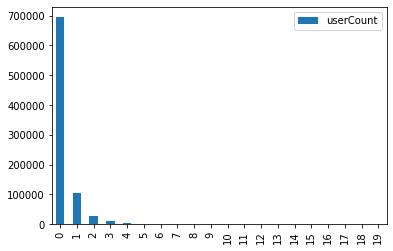

In [0]:
views.head(20).plot.bar(y='userCount')

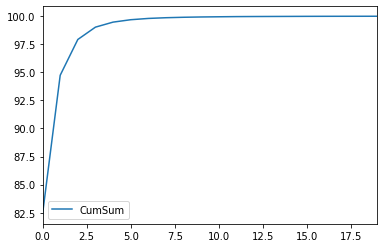

In [0]:
views['CumSum'] = (views['userCount'].cumsum() / distinct_users_count) * 100
views.head(20).plot.line(y='CumSum')